In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import random_statevector
from numpy import pi, random
import numpy as np 
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit.primitives.sampler import Sampler 
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit_aer import QasmSimulator

from qiskit import transpile
%matplotlib inline

key a: 0
key b: 0


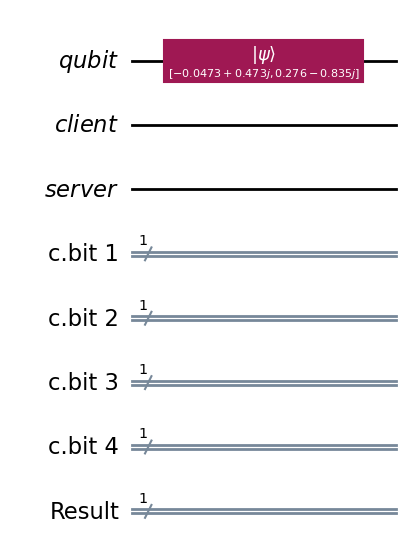

In [12]:
#Setup quantum server
qubit = QuantumRegister(1, "qubit")
client = QuantumRegister(1, "client")
server = QuantumRegister(1, "server")
cbit1 = ClassicalRegister(1, "c.bit 1")
cbit2 = ClassicalRegister(1, "c.bit 2")
cbit3 = ClassicalRegister(1, "c.bit 3")
cbit4 = ClassicalRegister(1, "c.bit 4")
result = ClassicalRegister(1, "Result")
qc = QuantumCircuit(qubit, client, server, cbit1, cbit2, cbit3, cbit4, result) 

# Prepare a random initial state |𝜓>
psi = random_statevector(2)
qc.initialize(psi.data, 0) 
        
# Randomly select encryption keys for each qubit
a, b = random.randint(0, 1), random.randint(0, 1)
#Client side encryption 
def encrypt_qubits(qc, qubit1, a, b):
    """Apply encryption with Pauli gates based on key bits a and b."""
    if a :
        qc.x(qubit1)
    if b :
        qc.z(qubit1)

# Encrypt the qubit
encrypt_qubits(qc, 0, a, b)


print(f"key a: {a}")
print(f"key b: {b}")

#qc.measure(client, cbit1)
#qc.measure(qubit, cbit2)

qc.draw('mpl')


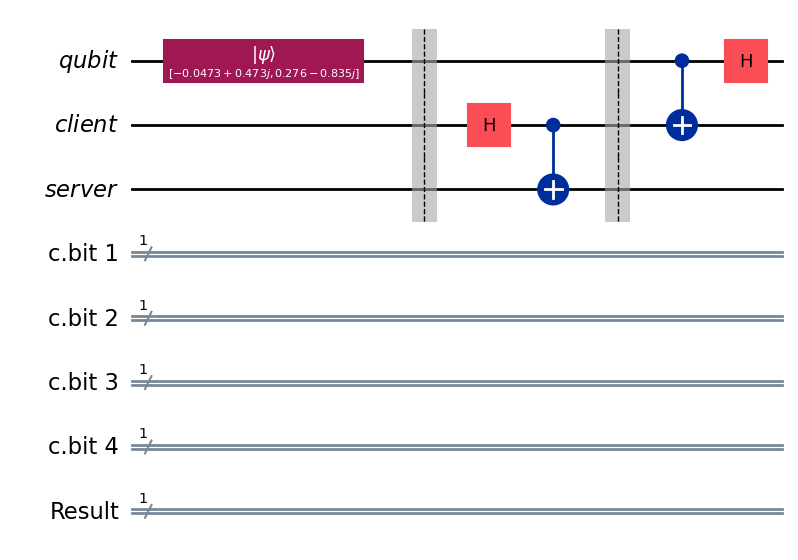

In [13]:
#prepare ebit used for teleportation 
qc.barrier()
qc.h(1)
qc.cx(1, 2)

#Client sending operation 
qc.barrier()
qc.cx(0, 1)
qc.h(0)

qc.draw('mpl')



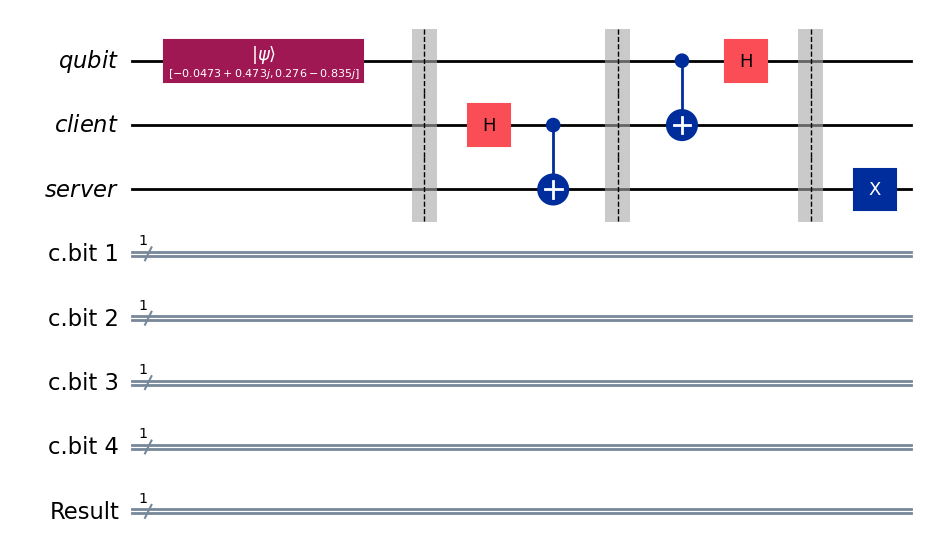

In [15]:
qc.barrier()

#define the server's operation function 
def server_operation(qc, qubit3, gate):
    """Apply a server operation based on a given identifier."""
    # Handling single qubit operations
    if gate == 'X':
        qc.x(qubit3)
    elif gate == 'Z':
        qc.z(qubit3)
    elif gate == 'H':
        qc.h(qubit3)
    elif gate == 'P':
        qc.p(np.pi/2, qubit3)  # Phase gate example


# Determine the gate for server operation based on the encryption keys
if a == 0 and b == 0:
    gate = 'X'  
elif a == 1 and b == 0:
    gate = 'Z' 
elif a == 0 and b == 1:
    gate = 'H'  
else:
    gate = 'P'  # Hadamard gate


server_operation(qc, 2, gate)
qc.draw('mpl')


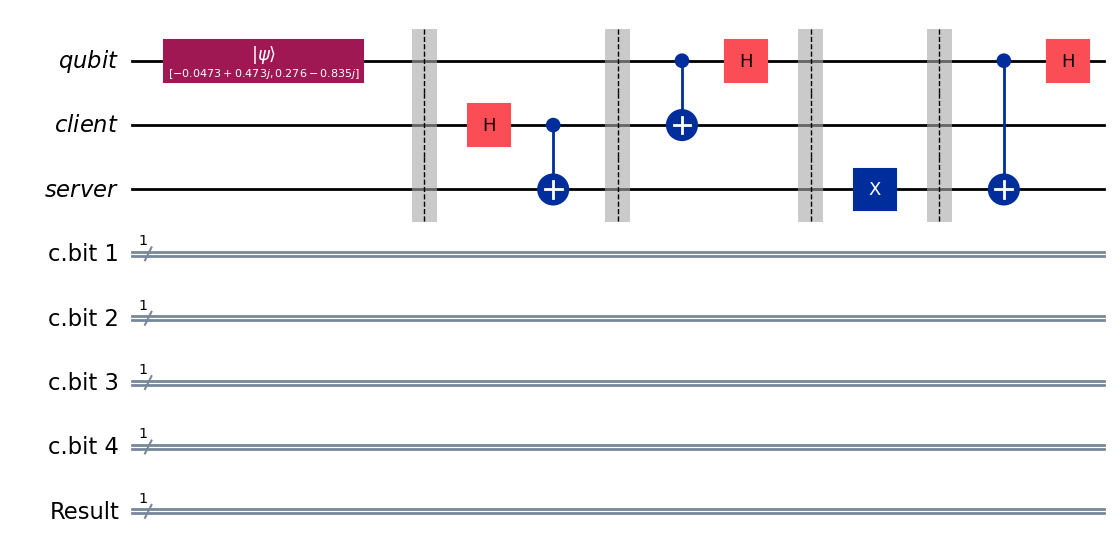

In [16]:
#Client sending operation 
qc.barrier()
qc.cx(0, 2)
qc.h(0)

qc.draw('mpl')


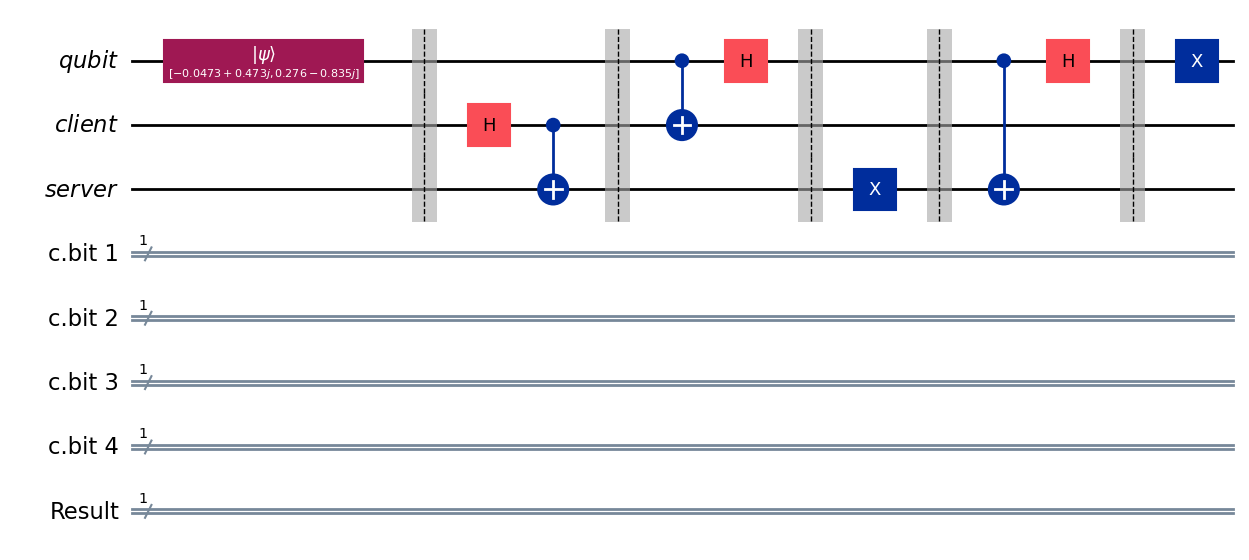

In [17]:

qc.barrier()
def decrypt(qc, qr, a, b):
    # Decide which scenario to apply based on a and b
    if a == 0 and b == 0:
        # Scenario 1: Xa Zb (not applied since both a and b are 0)
        qc.x(0)  # Apply an additional X for the example
    elif a == 1 and b == 0:
        # Scenario 2: Xa Zb (apply X since a is 1)
        qc.x(0)
        qc.z(0)  # Apply an additional Z for the example
    elif a == 0 and b == 1:
        # Scenario 3: Xb Za (apply X since b is 1)
        qc.x(0)
        qc.h(0)  # Apply H as additional gate
    else:
        # Scenario 4: Xa Za XOR b (both a and b are 1)
        qc.x(0)
        if a ^ b:  # This condition will be False since a == b == 1
            qc.z(0)
        qc.p(-np.pi/2, 0)  # Apply phase gate

decrypt(qc, 0, a, b)
#measure out from the first 2 Qubits and 2 Classical Bits
qc.draw('mpl')


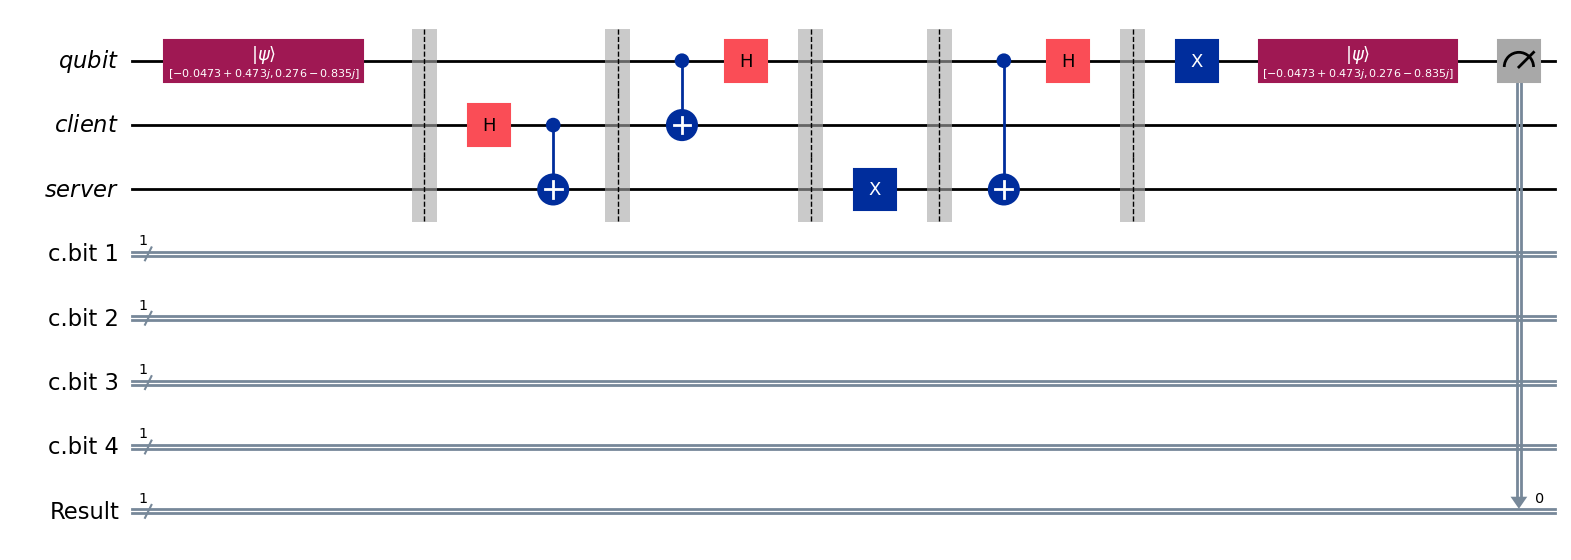

In [18]:
#Apply the inverse of the random unitary to B and measure 
qc.initialize(psi.data, qubit) 
result = ClassicalRegister(1, "Result")
#qc.add_resigter(result)
qc.measure(qubit, result)

qc.draw('mpl')

# Prepare a random initial state |𝜓>
#psi = random_statevector(2)
#qc.initialize(psi.data, 0) 

{'0 0 0 0 0': 228, '1 0 0 0 0': 772}


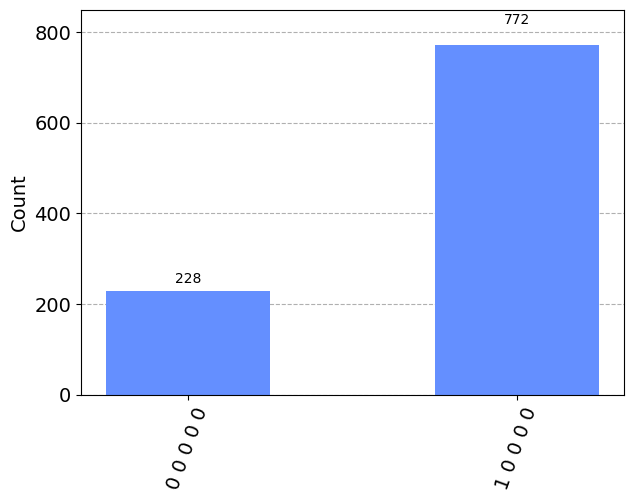

In [19]:

#Initialize a qasm simulator
simulator = QasmSimulator()

#Run and get the counts, which is a dictionary object 
result = simulator.run(qc, shots=1000).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

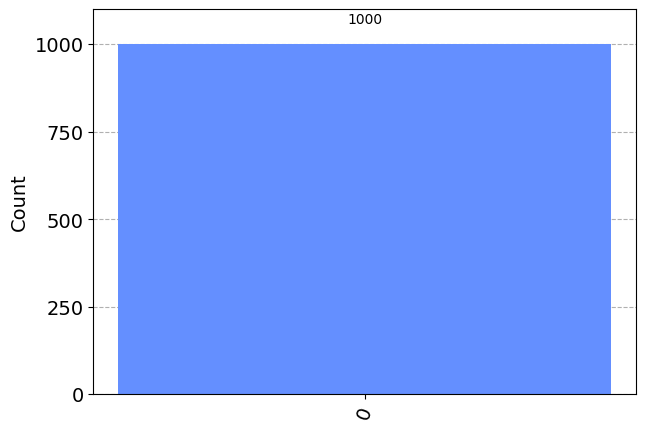

In [20]:
filtered_statistics = marginal_distribution(counts, [2])
display(plot_histogram(filtered_statistics))

key a: 0
key b: 0
key c: 0
key d: 0


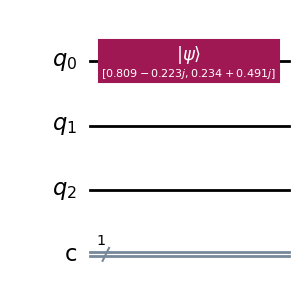

In [ ]:
qc.barrier()
def decrypt(qc, qr, a, b, gate):
    """Decrypt a qubit based on the applied gate and encryption keys."""
    if gate == 'X':
        # Decrypt based on server operation X
        if a == 0:
            qc.x(qr)
        if b == 0:
            qc.z(qr)
        qc.x(qr)
    elif gate == 'Z':
        # Decrypt based on server operation Z
        if a == 1:
            qc.x(qr)
        qc.z(qr)
        if b == 0:
            qc.z(qr)
    elif gate == 'H':
        # Decrypt based on server operation H
        if a == 0:
            qc.z(qr)
        if b == 1:
            qc.x(qr)
        qc.h(qr)
    elif gate == 'P':
        # Decrypt based on server operation P
        # Undo Z^{a XOR b}
        if a != b:  # This checks if a XOR b == 1
            qc.z(qr)
        # Undo X^a
        if a == 1:
            qc.x(qr)
        # Undo P (inverse phase shift)
            qc.p(-np.pi/2, qr)


decrypt(qc, 0, a, b, gate)
#measure out from the first 2 Qubits and 2 Classical Bits
qc.draw('mpl')